# Vocabulary analysis
In this notebooks, I'll look for out-of-vocabulary words in each pairwise comparison of corpora. The more out-of-vocabulary words for a given pair, the less similar they are to one another. We expect that SciERC and PICKLE will have more overlapping vocabulary.

In [1]:
import jsonlines
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import pandas as pd
import numpy as np

# Importing my own Dataset class
import sys
sys.path.append('../models/corpus_comparison/')
from dataset import Dataset

For this analysis, we'll use the SciERC, GENIA, ChemProt, SeeDev and PICKLE corpora to get the sets of tokens that make up the three corpora. We'll then look for out-of-vocabulary words in the comparison of each dataset versus PICKLE. Based on the pre-trained model results, in which SciERC outperformed all other models on the PICKLE corpus, we expect to see that there are more out-of-vocabulary words in the GENIA, ChemProt, and SeeDev-PICKLE comparisons than in the SciERC-PICKLE comparison.
### Getting corpus vocabularies

#### Downloading SciERC and GENIA data
We'll use the code provided in the [DyGIE++](https://github.com/dwadden/dygiepp) repo for this purpose, as well as our processed version of SeeDev, running the following commands from the root of the `dygiepp` repo:

```
bash ./scripts/data/get_scierc.sh
```

```
bash ./scripts/data/get_genia.sh
```

```
bash ./scripts/data/get_chemprot.sh
```

### Comparing vocabularies
Now that we have all the datasets, we can compare them. This is done with the script `out_of_vocab_comparison.py`, found in the `models/OOV_comparison` directory.

<br>

*A summary of the comparisons:* For each pair of datasets, a total of 6 metrics were calculated. For each of unigrams, bigrams, and trigrams, the datasets were compared in both directions, and the number of out-of-vocabulary words for that comparison were computed. In order to be able to compare the differences between PICKLE/GENIA and PICKLE/SciERC, the comparisons were normalized by the number of words of that n-gram length in the comparison corpus, making the final calculation equivalent to:

```len(set(ngrams in PICKLE) - set(ngrams in GENIA/SciERC)) / len(ngrams in GENIA/SciERC)```

#### Commands used to generate comparisons
Below i an example of how the script is used to generate the information we'll use in our graph below. The relative paths here are specific to my local filesystem/data directory structure, which doesn't come along with this repository. These commands were run form the `models/corpus_comparison/` directory.

To compare GENIA to PICKLE:
```
python out_of_vocab_comparison.py \
    pickle \
    ../../data/straying_off_topic_data/unified_annotations_processed/jsonl_file/PICKLE_250_abstracts_entities_and_relations_FINAL_05Jul2023_CORRECTED_TRAIN.jsonl \
    genia \
    ~/Shiu_lab/dygiepp/data/genia/processed-data/json-coref-ident-only/train.json \
    ../../data/straying_off_topic_data/corpus_comparison/ \
    19Jul2023_pickle_vs_genia
```


#### Looking at comparison outputs
Now, lets read in the data and see what the situation is.

In [3]:
path_prefix = '../data/straying_off_topic_data/corpus_comparison/'
ind_paths = {
    'pickle_vs_genia': '19Jul2023_pickle_vs_genia_oov_comparison.jsonl',
    'pickle_vs_seedev': '19Jul2023_pickle_vs_seedev_oov_comparison.jsonl',
    'pickle_vs_chemprot': '19Jul2023_pickle_vs_chemprot_oov_comparison.jsonl',
    'pickle_vs_scierc': '19Jul2023_pickle_vs_scierc_oov_comparison.jsonl'
}

In [5]:
comparisons = {}
for comp_name, fname in ind_paths.items():
    comp = []
    with jsonlines.open(f'{path_prefix}{fname}') as reader:
        for obj in reader:
            comp.append(obj)
    comparisons[comp_name] = comp

To better visualize the situation, let's make a bar plot!

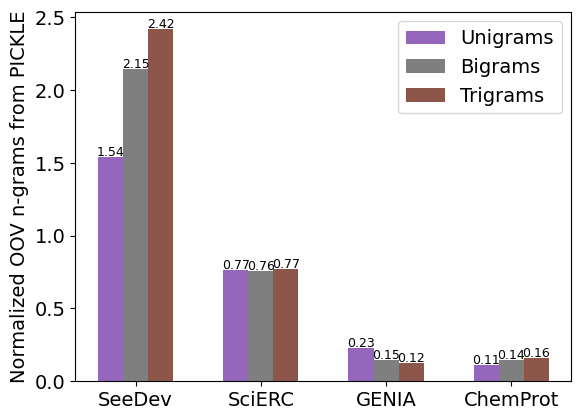

In [15]:
label_map = {
    'pickle_vs_seedev': 'SeeDev',
    'pickle_vs_scierc': 'SciERC',
    'pickle_vs_genia': 'GENIA',
    'pickle_vs_chemprot': 'ChemProt'
}
xlabs = list(label_map.values())
unigrams = [comparisons[lab][0]['unigrams_oov_pickle_frac'] for lab in label_map.keys()]
bigrams = [comparisons[lab][0]['bigrams_oov_pickle_frac'] for lab in label_map.keys()]
trigrams = [comparisons[lab][0]['trigrams_oov_pickle_frac'] for lab in label_map.keys()]

x = np.arange(len(xlabs))
x = 0.5*x
width = 0.1

fig, ax = plt.subplots()
ax.bar(x - width, unigrams, width, color='tab:purple', label='Unigrams')
ax.bar(x, bigrams, width, color='tab:grey', label='Bigrams')
ax.bar(x + width, trigrams, width, color='tab:brown', label='Trigrams')

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
               (bar.get_x() + bar.get_width() / 2,
               bar.get_height()), ha='center', va='top',
               size=9, xytext=(0,8),
               textcoords='offset points')

plt.ylabel('Normalized OOV n-grams from PICKLE')
plt.xticks(x, xlabs)
plt.legend(loc='upper right')

plt.savefig('../data/straying_off_topic_data/corpus_comparison/figures/oov_plot.png', bbox_inches='tight', dpi=300)

Here, we see that SeeDev follows our expectation, but that none of the other corpora have more OOV words than SciERC. 